In [5]:
from pl_modules.myUnet_module import MyUnetModule
from modules.transforms import KspaceUNetDataTransform
from pathlib import Path
from fastmri.pl_modules import FastMriDataModule
from fastmri.data.subsample import create_mask_for_mask_type
from torch.nn import L1Loss
from modules.transforms import KspaceUNetSample, kspace_to_mri
import matplotlib.pyplot as plt

import torch
torch.manual_seed(1234)  # For dataset shuffle
import numpy as np
np.random.seed(41234)


path = "latent_data/"
config = {
        "mask_type": "equispaced_fraction",
        "center_fractions": [0.04],
        "accelerations": [8],
        "with_dc": True,
        "loss_domain": "ssim", 
        "n_channels": 128,
        "soft_dc": False,
        "criterion": L1Loss()
    }
mask_func = create_mask_for_mask_type(
    config["mask_type"], config["center_fractions"], config["accelerations"]
)

train_transform = KspaceUNetDataTransform(mask_func=mask_func, use_seed=False)
val_transform = KspaceUNetDataTransform(mask_func=mask_func)
test_transform = KspaceUNetDataTransform()
# ptl data module - this handles data loaders
data_module = FastMriDataModule(
    data_path=Path("/vol/datasets/cil/2021_11_23_fastMRI_data/knee/unzipped"),
    challenge="singlecoil",
    train_transform=train_transform,
    val_transform=val_transform,
    test_transform=test_transform,
    combine_train_val=False,
    test_split="test",
    sample_rate=None,
    batch_size=1,
    num_workers=4,
    distributed_sampler=False,
    use_dataset_cache_file=False
)
model = MyUnetModule.load_from_checkpoint("6fmyvljd/myunet-epoch=01.ckpt")
train_dl = data_module.train_dataloader()

In [6]:
batch = next(iter(train_dl))

In [3]:
def process_batch(batch, zero=False, on_residual=False):
    input = batch.masked_kspace.permute(0,3,1,2).contiguous()
    input, mean, std = model.norm(input)
    lst, stack = model.downsample(input.to("cuda"))
    # print(lst.shape)
    if zero:
        if on_residual: 
            new_stack = []
            for residual in stack:
                # print(residual.shape)
                new_residual = torch.zeros_like(residual).to("cuda")
                new_stack.append(new_residual)
            stack = new_stack
        else:
            lst = torch.zeros_like(lst).to("cuda")
    # print(stack)
    output = model.upsample(lst, stack)
    output = model.unnorm(output, mean.to("cuda"), std.to("cuda"))
    output = output.permute(0,2,3,1).contiguous()
    # zero = torch.zeros(1, 1, 1, 1).to(output)
    # soft_dc = torch.where(batch.mask.to("cuda"), output - batch.masked_kspace.to("cuda"), zero)
    # output = output - soft_dc
    mri = kspace_to_mri(output).squeeze(0).detach().cpu().numpy()
    mri_original = kspace_to_mri(batch.full_kspace).squeeze(0)
    mri_undersampled = kspace_to_mri(batch.masked_kspace).squeeze(0)
    fig, ax = plt.subplots(1,3,figsize=(8,5))
    fig.subplots_adjust(wspace=0.0)

    ax[0].imshow(mri_original,'gray')
    ax[0].set_title("Original Mri Image")

    ax[1].imshow(mri_undersampled,'gray')
    ax[1].set_title("Undersampled Mri Image")

    ax[2].imshow(mri, 'gray')
    ax[2].set_title("Reconstructed (before DC) Mri Image")

    # remove all the ticks (both axes), and tick labels
    for axes in ax:
        axes.set_xticks([])
        axes.set_yticks([])
    # remove the frame of the chart
    for axes in ax:
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
    # remove the white space around the chart
    plt.tight_layout()
    plt.show()

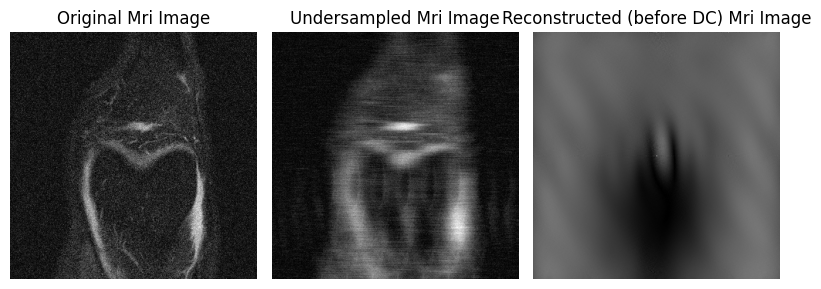

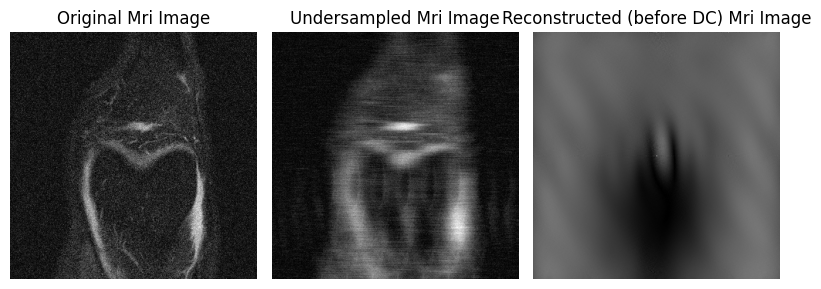

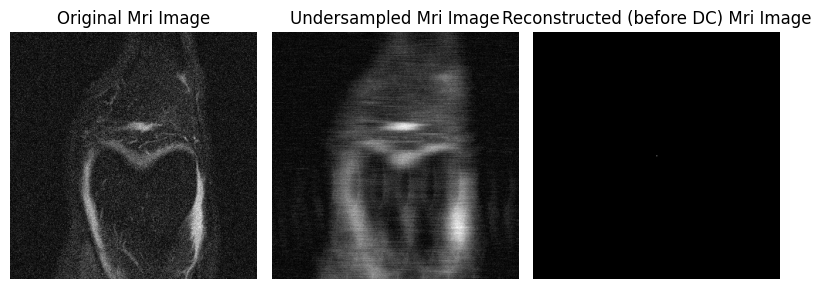

In [7]:
process_batch(batch)
process_batch(batch, zero=True, on_residual=True)
process_batch(batch, zero=True)